In [ ]:
# (C) Copyright IBM Corp. 2019, 2020, 2021, 2022.

#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at

#           http://www.apache.org/licenses/LICENSE-2.0

#     Unless required by applicable law or agreed to in writing, software
#     distributed under the License is distributed on an "AS IS" BASIS,
#     WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#     See the License for the specific language governing permissions and
#     limitations under the License.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

os.environ["engine"] = "pytorch"

from simulai.regression import ConvolutionalNetwork
from simulai.optimization import Optimizer
from simulai.metrics import L2Norm

### Choosing model parameters and constructing space and time grids

In [2]:
N = 10_000
K_low = 64
K = 512
n_inputs = 1
n_outputs = 1
lr = 1e-4
train_fraction = 0.9
n_samples_train = int(train_fraction*N)
n_epochs = 3_00
L = 20
t_max = 10
omega_x = 3*np.pi
omega_t = 5*np.pi
device = 'gpu'

x_l = np.linspace(0, L, K_low)
x = np.linspace(0, L, K)
t = np.linspace(0, t_max, N)

T, X = np.meshgrid(t, x, indexing = "ij")
T_l, X_l = np.meshgrid(t, x_l, indexing = "ij")

### Defining a function for constructing the manufactured field $U$ and a nonlinear operation $F$ over it. 

In [3]:
def u(x, t):
    
    return np.sin(2*np.pi*x*(np.sin(2*np.pi*t/t_max))/L)*np.cos(3*np.pi*t*(np.sin(2*np.pi*x/L))/t_max)

def f(u):
    
    return -2*(u**2)*np.cos(np.pi*u/u.max())*np.sin(2*np.pi*u/u.max())

### Constructing the low fidelity input dataset $U_l$ and the high fidelity output dataset $F$.

In [4]:
U_l_raw = u(X_l, T_l)
U_raw = u(X, T)
F_raw = f(U_raw)

U_l = (U_l_raw - U_l_raw.min())/(U_l_raw.max() - U_l_raw.min())
U = (U_raw - U_raw.min())/(U_raw.max() - U_raw.min())
F = (F_raw - F_raw.min())/(F_raw.max() - F_raw.min())

### Visualizing these datasets.

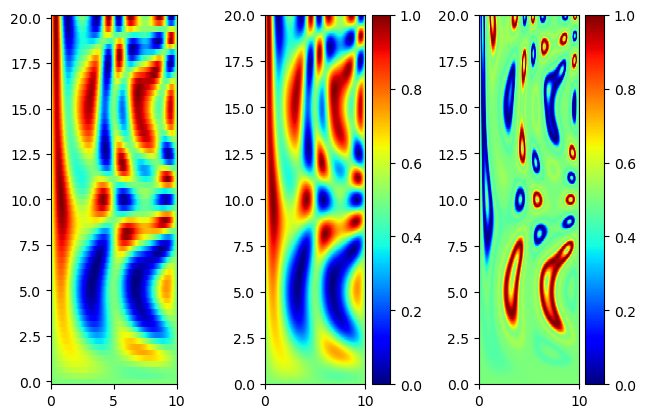

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.pcolormesh(T_l, X_l, U_l, cmap="jet", shading="auto")
values2 = ax2.pcolormesh(T, X, U, cmap="jet", shading="auto")
values3 = ax3.pcolormesh(T, X, F, cmap="jet", shading="auto")
fig.colorbar(values2, ax=ax2)
fig.colorbar(values3, ax=ax3)
fig.subplots_adjust(wspace=.7, right=0.99, hspace=0)
plt.show()
plt.show()

### Neural netwok configuring and instantiation.
#### Experiment 1: Enlarging resolution.

#### Preparing the training  and test sub-datasets.

In [6]:
U_train = U_l[:n_samples_train]
F_train = U[:n_samples_train]

U_test = U_l[n_samples_train:]
F_test = U[n_samples_train:] 

#### Neural Network Configuration

In [13]:
n_epochs = 50

optimizer_config = {'lr': lr}

layers = [
              {'in_channels': n_inputs, 'out_channels': 64, 'kernel_size': 3, 
               'stride': 1, 'padding': 1,
               'after_conv': {'type': 'upsample', 'scale_factor': 2}},
              {'in_channels': 64, 'out_channels': 16, 'kernel_size': 3, 
               'stride': 1, 'padding': 1,
               'after_conv': {'type': 'upsample', 'scale_factor': 2}},
              {'in_channels': 16, 'out_channels': 4, 'kernel_size': 3, 
               'stride': 1, 'padding': 1,
               'after_conv': {'type': 'upsample', 'scale_factor': 2}},
               {'in_channels': 4, 'out_channels': n_outputs, 'kernel_size': 3, 
               'stride': 1, 'padding': 1}
         ]

# Instantiating network
convnet = ConvolutionalNetwork(layers=layers, activations='tanh', case="1d", transpose=False)

#### A view of the convolutional network architecture.

In [14]:
convnet.summary(input_data=U_train)

OrderedDict([ ( 'Conv1d_0',
                {'Input shape': [None, 1, 64], 'Output shape': [None, 64, 64]}),
              ('Activation_0', Tanh()),
              ( 'Upsample_0',
                { 'Input shape': [None, 64, 64],
                  'Output shape': [None, 64, 128]}),
              ( 'Conv1d_1',
                { 'Input shape': [None, 64, 128],
                  'Output shape': [None, 16, 128]}),
              ('Activation_1', Tanh()),
              ( 'Upsample_1',
                { 'Input shape': [None, 16, 128],
                  'Output shape': [None, 16, 256]}),
              ( 'Conv1d_2',
                { 'Input shape': [None, 16, 256],
                  'Output shape': [None, 4, 256]}),
              ('Activation_2', Tanh()),
              ( 'Upsample_2',
                { 'Input shape': [None, 4, 256],
                  'Output shape': [None, 4, 512]}),
              ( 'Conv1d_3',
                { 'Input shape': [None, 4, 512],
                  'Output shape': [No

#### Training. 

In [15]:
# Instantiating optimizer
params = {'lambda_1': 0., 'lambda_2': 0.}
optimizer = Optimizer('adam', params=optimizer_config)

### Training
optimizer.fit(op=convnet, input_data=U_train, target_data=F_train,
              n_epochs=n_epochs, loss="rmse", params=params, batch_size=200, device=device)

Executing batchwise optimization loop.
loss: 0.057304918766021736

#### Evaluation. 

In [10]:
### Evaluating
F_test_eval = convnet.eval(input_data=U_test)

F_test_eval = F_test_eval[:, 0, ...]

l2norm = L2Norm()
error = 100*l2norm(data=F_test_eval, reference_data=F_test, relative_norm=True)

print(f"Evaluation error: {error} %")

### Visualizing
test_indices = np.arange(0, N - n_samples_train, 1000).astype(int).tolist()

Evaluation error: 31.802435867333074 %


#### Visualization.

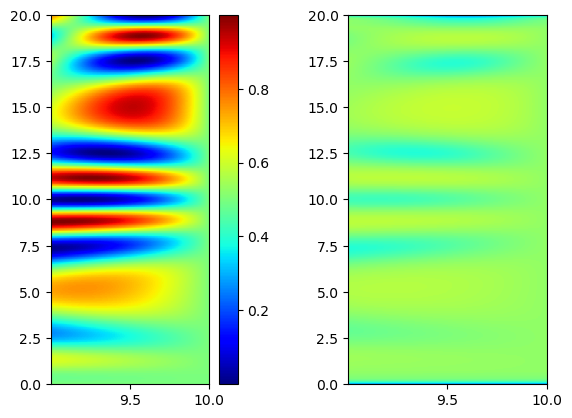

In [11]:
color_norm = Normalize(vmin=min(F_test.min(),F_test_eval.min()),
                           vmax=max(F_test.max(), F_test_eval.max()))

fig, (ax1, ax2) = plt.subplots(1, 2)
values1 = ax1.pcolormesh(T[n_samples_train:], X[n_samples_train:], F_test, cmap="jet", shading="auto", norm=color_norm)
values2 = ax2.pcolormesh(T[n_samples_train:], X[n_samples_train:], F_test_eval, cmap="jet", shading="auto", norm=color_norm)
fig.colorbar(values1, ax=ax1)
fig.subplots_adjust(wspace=.5, right=0.9, hspace=0)
plt.show()